In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'instacart-market-basket-analysis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F6644%2F44315%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240721%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240721T110125Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Daf2c9c5080231c927084acea577515823d8dfbbfd07ff92d28cbe398131cd9b34cb74d60cf5b8d6b49ddcaa1ebde5321c04017db793d33c2f45e3050924b14f266682ac26c50af446814d852558136bd46aaadf23557eb15edf1a19f5febb8a47d64458c1e28bee42e3139a412ab30eab2f092a13a82527deee5cb3244caf58f0c49328c6c2c948075931e48c56bbb0010950f0d4cb5e4b9af75892a493483eba331d5ecbdb110243e1b7dcba58408f92ecbdcde40f995b2da1f9f605b30edf134448ea89e79c6f47e524e0eaca54df46fd50225f33505ca8eb4a525facb27cf1b5e01de608db59b6f9a939843d015fc04aa50e08f3189c906d4b5e1191ada56'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 205835909 bytes downloaded
Downloaded and uncompressed: instacart-market-basket-analysis
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv.zip
/kaggle/input/instacart-market-basket-analysis/departments.csv.zip
/kaggle/input/instacart-market-basket-analysis/sample_submission.csv.zip
/kaggle/input/instacart-market-basket-analysis/products.csv.zip
/kaggle/input/instacart-market-basket-analysis/aisles.csv.zip
/kaggle/input/instacart-market-basket-analysis/orders.csv.zip
/kaggle/input/instacart-market-basket-analysis/order_products__train.csv.zip


### Import thư viện và unzip dữ liệu

In [ ]:
from zipfile import ZipFile
import duckdb
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input/instacart-market-basket-analysis/'):
    for filename in filenames:
        archive = ZipFile(os.path.join(dirname, filename), mode='r')
        archive.extractall(path="/kaggle/working")
        archive.close()

print(check_output(["ls", "../working"]).decode("utf8"))

aisles.csv
departments.csv
__MACOSX
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



# Tổng quan về dữ liệu

## Dữ liệu đơn hàng

In [ ]:
order = pd.read_csv('/kaggle/working/orders.csv')
order_products_prior = pd.read_csv('/kaggle/working/order_products__prior.csv')
order_products_train = pd.read_csv('/kaggle/working/order_products__train.csv')

## Những dữ liệu khác

In [ ]:
deparment = pd.read_csv('/kaggle/working/departments.csv')
product = pd.read_csv('/kaggle/working/products.csv')
aisle = pd.read_csv('/kaggle/working/aisles.csv')

#### Nhìn tổng quan về Dữ liệu:

Thông tin chung về Instacart : Instacart là một dịch vụ giao hàng tạp hóa trực tuyến. Không giống như các cửa hàng tạp hóa cung cấp hàng hóa của riêng họ, Instacart làm việc với hàng nghìn người mua sắm cá nhân, những người sẽ đến cửa hàng bạn chọn, mua mọi thứ trong danh sách mua sắm của bạn và giao hàng ngay trước cửa nhà bạn.  https://www.instacart.com/store

Toàn bộ mô hình kinh doanh liên quan tới 3 nhóm đối tượng:

- Người dùng
- Người mua sắm cá nhân
- Cửa hàng

1. Dữ liệu order có thông tin về đơn hàng như:

     - order_id: ID của đơn hàng.
     - user_id: ID của khách hàng.
     - eval_set: kiểu dataset của dòng dữ liệu. Ở đây có thể là: train, prior, test.
     - order_number: số thức tự đơn hàng của khách hàng.
     - order_dow: ngày đặt hàng trong tuần.
     - order_hour_of_day: thời gian giờ đặt hàng trong ngày.
     - day_since_prior_order: khoảng cách thời gian so với lần đặt hàng trước.

2. Dữ liệu order_products_prior và order_products_train: sẽ cùng một kiểu thông tin chỉ khác là dành cho tập data train hay prior:

    - order_id: ID của đơn hàng.
    - product_id: ID của sản phẩm.
    - add_to_cart_order: thứ tự thêm vào giỏ hàng của đơn hàng.
    - reordered: sản phẩm trong đơn hàng được đặt hàng lại hay không.

3. Dữ liệu product có các thông tin sau:
    - product_id: ID của sản phẩm.
    - product_name : tên của sản phẩm.
    - aisle_id: id của gian hàng của sản phẩm.
    - department_id: id của ngành/nhóm của sản phẩm.

4. Dữ liệu aisle có thông tin sau:
    - aisle_id: id gian hàng của sản phẩm.
    - aisle: tên gian hàng của sản phẩm.


5. Dữ liệu deparment có thông tin sau:
    - deparment_id: id ngành/nhóm của sản phẩm.
    - deparment: tên ngành/nhóm của sản phẩm



In [ ]:
# các ngành/nhóm hàng
print(sorted(deparment['department']))

['alcohol', 'babies', 'bakery', 'beverages', 'breakfast', 'bulk', 'canned goods', 'dairy eggs', 'deli', 'dry goods pasta', 'frozen', 'household', 'international', 'meat seafood', 'missing', 'other', 'pantry', 'personal care', 'pets', 'produce', 'snacks']


In [ ]:
# các gian hàng
print(sorted(aisle['aisle'].values))

['air fresheners candles', 'asian foods', 'baby accessories', 'baby bath body care', 'baby food formula', 'bakery desserts', 'baking ingredients', 'baking supplies decor', 'beauty', 'beers coolers', 'body lotions soap', 'bread', 'breakfast bakery', 'breakfast bars pastries', 'bulk dried fruits vegetables', 'bulk grains rice dried goods', 'buns rolls', 'butter', 'candy chocolate', 'canned fruit applesauce', 'canned jarred vegetables', 'canned meals beans', 'canned meat seafood', 'cat food care', 'cereal', 'chips pretzels', 'cleaning products', 'cocoa drink mixes', 'coffee', 'cold flu allergy', 'condiments', 'cookies cakes', 'crackers', 'cream', 'deodorants', 'diapers wipes', 'digestion', 'dish detergents', 'dog food care', 'doughs gelatins bake mixes', 'dry pasta', 'eggs', 'energy granola bars', 'energy sports drinks', 'eye ear care', 'facial care', 'feminine care', 'first aid', 'food storage', 'fresh dips tapenades', 'fresh fruits', 'fresh herbs', 'fresh pasta', 'fresh vegetables', 'fr

In [ ]:
order.describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,3421083.0,1.710542e+06,987581.739823,1.0,855271.5,1710542.0,2565812.5,3421083.0
user_id,3421083.0,1.029782e+05,59533.717794,1.0,51394.0,102689.0,154385.0,206209.0
order_number,3421083.0,1.715486e+01,17.733164,1.0,5.0,11.0,23.0,100.0
order_dow,3421083.0,2.776219e+00,2.046829,0.0,1.0,3.0,5.0,6.0
order_hour_of_day,3421083.0,1.345202e+01,4.226088,0.0,10.0,13.0,16.0,23.0
days_since_prior_order,3214874.0,1.111484e+01,9.206737,0.0,4.0,7.0,15.0,30.0


In [ ]:
print('Data size of the order Dataset is {}'.format(order.shape))
print('Data size of the order_products_prior Dataset is {}'.format(order_products_prior.shape))
print('Data size of the order_products_train Dataset is {}'.format(order_products_train.shape))
print('Data size of the products Dataset is {}'.format(product.shape))
print('Data size of the departments Dataset is {}'.format(deparment.shape))
print('Data size of the aisles Dataset is {}'.format(aisle.shape))

Data size of the order Dataset is (3421083, 7)
Data size of the order_products_prior Dataset is (32434489, 4)
Data size of the order_products_train Dataset is (1384617, 4)
Data size of the products Dataset is (49688, 4)
Data size of the departments Dataset is (21, 2)
Data size of the aisles Dataset is (134, 2)


In [ ]:
# deal with missing value of the column day_since_prior_order
order.days_since_prior_order = order.days_since_prior_order.fillna(0)

## get information about the number line, number line by reordered of each order on eval_set = train
train_0 = order_products_train[order_products_train.reordered == 0].groupby(['order_id','reordered'])['product_id'].count().reset_index()
train_1 = order_products_train[(order_products_train.reordered == 1)].groupby(['order_id','reordered'])['product_id'].count().reset_index()
train_0.rename(columns={'product_id':'reordered_0'}, inplace=True)
train_0 = train_0.drop('reordered', axis = 1)
train_1.rename(columns={'product_id':'reordered_1'}, inplace=True)
train_1 = train_1.drop('reordered', axis = 1)
train_reordered = pd.merge(train_1, train_0, how = 'outer', on = 'order_id')
train_reordered.fillna({'reordered_1':0, 'reordered_0':0}, inplace=True)
del train_0
del train_1


## get information about the number line, number line by reordered of each order on eval_set = prior
prior_0 = order_products_prior[order_products_prior.reordered == 0].groupby(['order_id','reordered'])['product_id'].count().reset_index()
prior_1 = order_products_prior[(order_products_prior.reordered == 1)].groupby(['order_id','reordered'])['product_id'].count().reset_index()
prior_0.rename(columns={'product_id':'reordered_0'}, inplace=True)
prior_0 = prior_0.drop('reordered', axis = 1)
prior_1.rename(columns={'product_id':'reordered_1'}, inplace=True)
prior_1 = prior_1.drop('reordered', axis = 1)
prior_reordered = pd.merge(prior_1, prior_0, how = 'outer', on = 'order_id')
prior_reordered.fillna({'reordered_1':0, 'reordered_0':0}, inplace=True)
del prior_0
del prior_1

## concat two datafarm: train and prior

df_reordered = pd.concat([prior_reordered,train_reordered])
df_reordered = df_reordered.sort_values(by = 'order_id', ascending= True).reset_index()
df_reordered = df_reordered.drop('index', axis = 1)

## deal with missing value of the column reordered_0
df_reordered.fillna({'reordered_1':0, 'reordered_0':0}, inplace=True)

## get information user_id from the Order Dataset

df_reordered = df_reordered.merge(order[['user_id','order_id','order_number','days_since_prior_order']], how = 'left', on = 'order_id')

df_reordered['total_line'] = df_reordered.reordered_0 + df_reordered.reordered_1


## create a datafarm about order detail

cus_orderdetail_df = df_reordered.groupby(['user_id']).agg({
    'reordered_0': 'sum',
    'reordered_1': 'sum',
    'total_line' :'sum',
    'order_number': 'count',
    'days_since_prior_order': 'mean'
}).reset_index()

cus_orderdetail_df.rename(columns={'days_since_prior_order':'recency','order_number': 'fequency'}, inplace=True)

In [ ]:
cus_orderdetail_df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,206209.0,103105.000000,59527.555167,1.0,51553.0,103105.000000,154657.000000,206209.0
reordered_0,206209.0,67.231527,56.876842,1.0,28.0,51.000000,89.000000,728.0
reordered_1,206209.0,96.772498,160.293373,0.0,13.0,37.000000,106.000000,3275.0
total_line,206209.0,164.004025,206.014923,3.0,44.0,90.000000,196.000000,3725.0
fequency,206209.0,16.226658,16.662238,3.0,6.0,10.000000,20.000000,100.0
recency,206209.0,13.201294,5.460373,0.0,8.8,13.041667,17.428571,27.0


In [ ]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data[measure])

    sns.set(style='darkgrid', font_scale=1.0)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data[measure], fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data[measure], plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data[measure].skew(), data[measure].kurt()), loc='center')

    plt.tight_layout()
    plt.show()

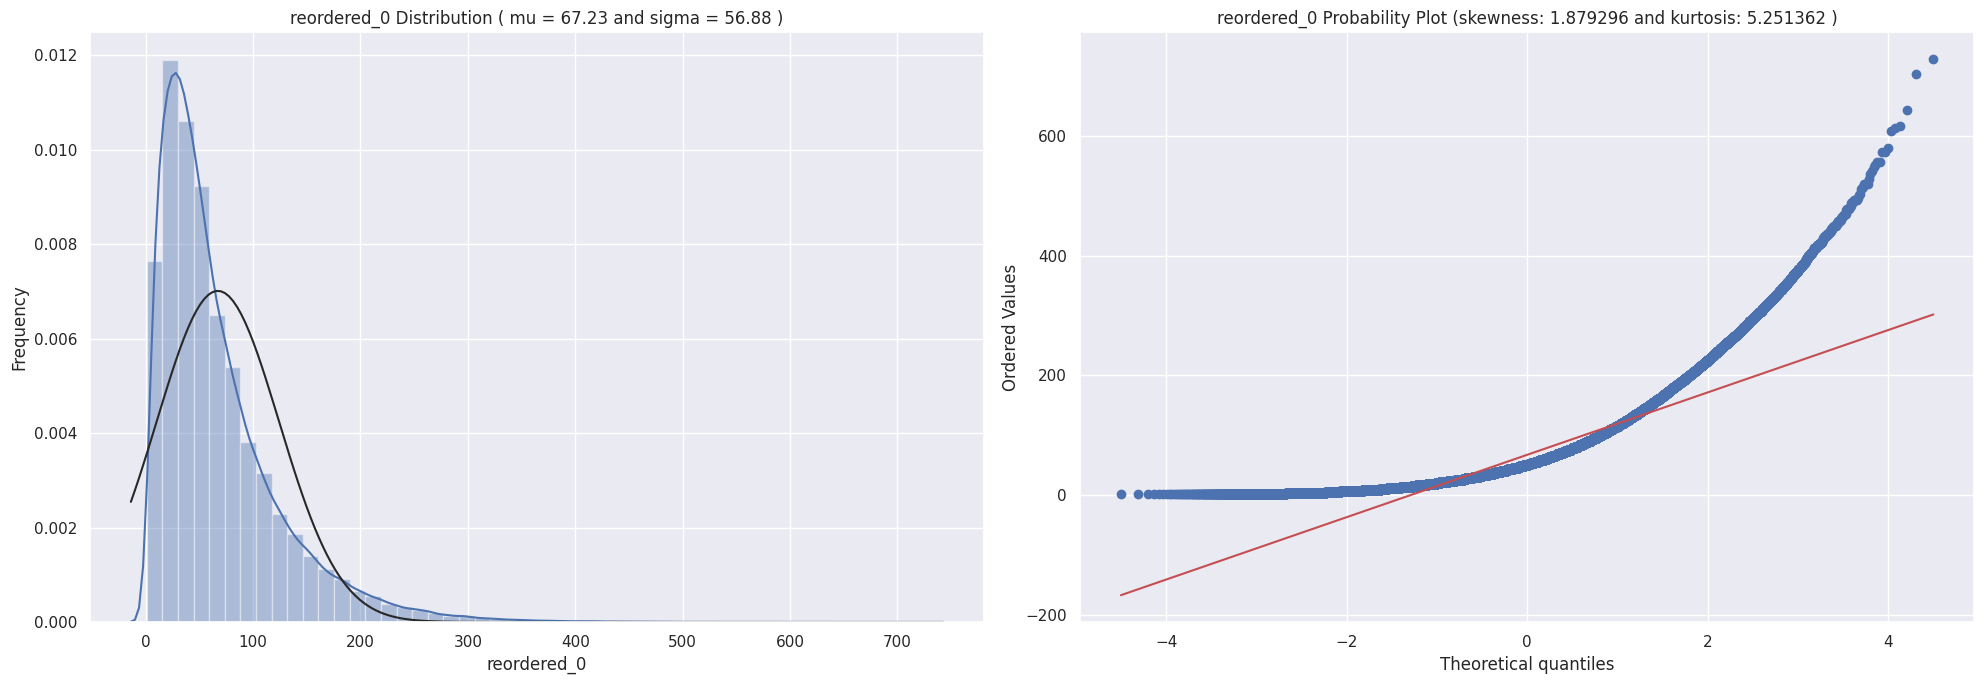

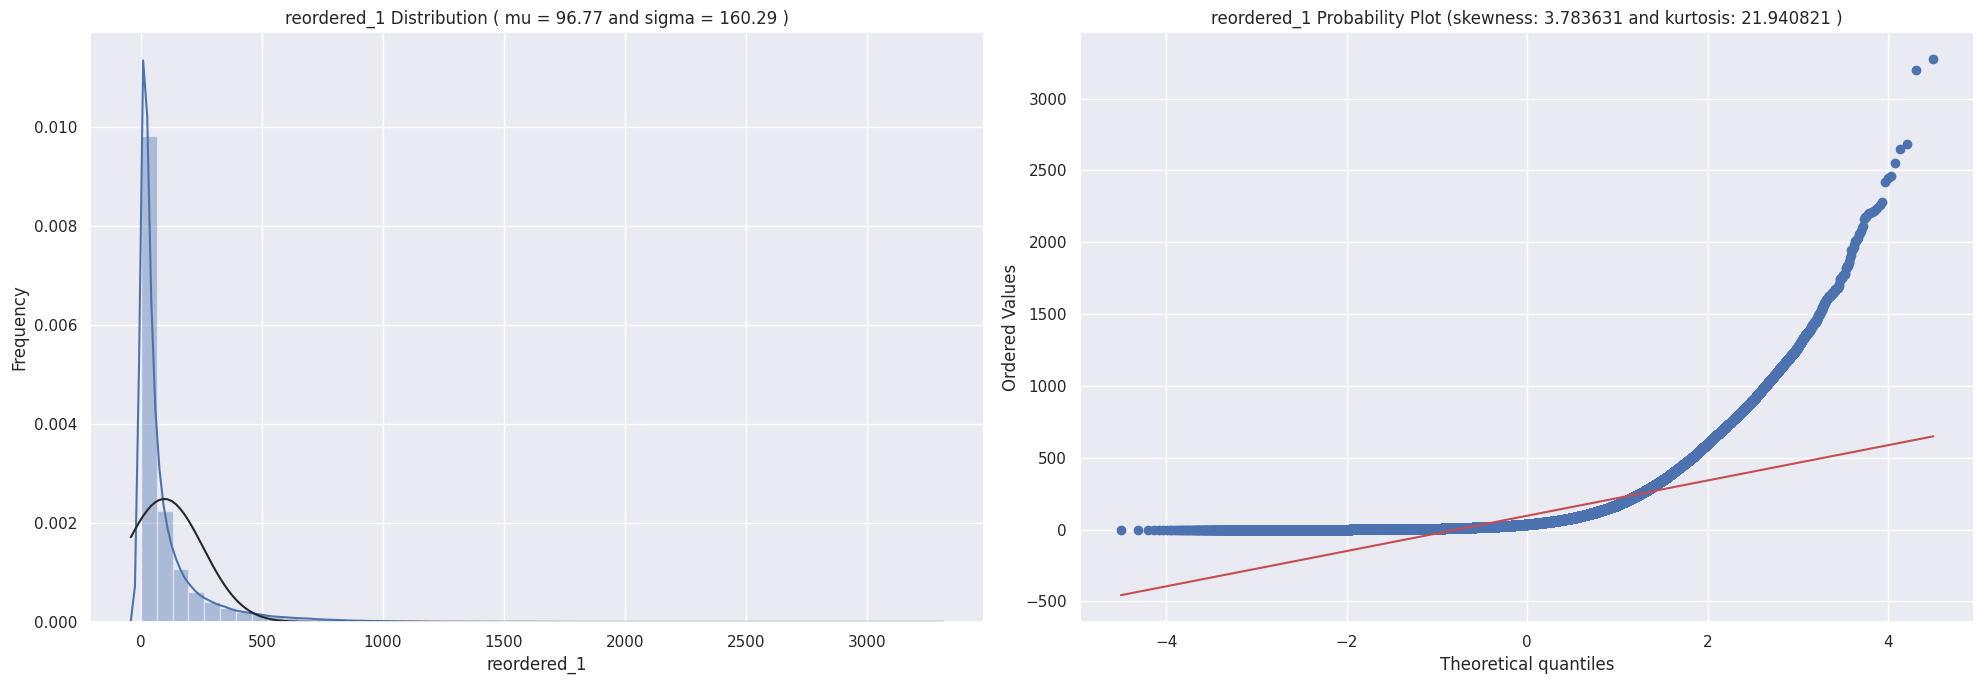

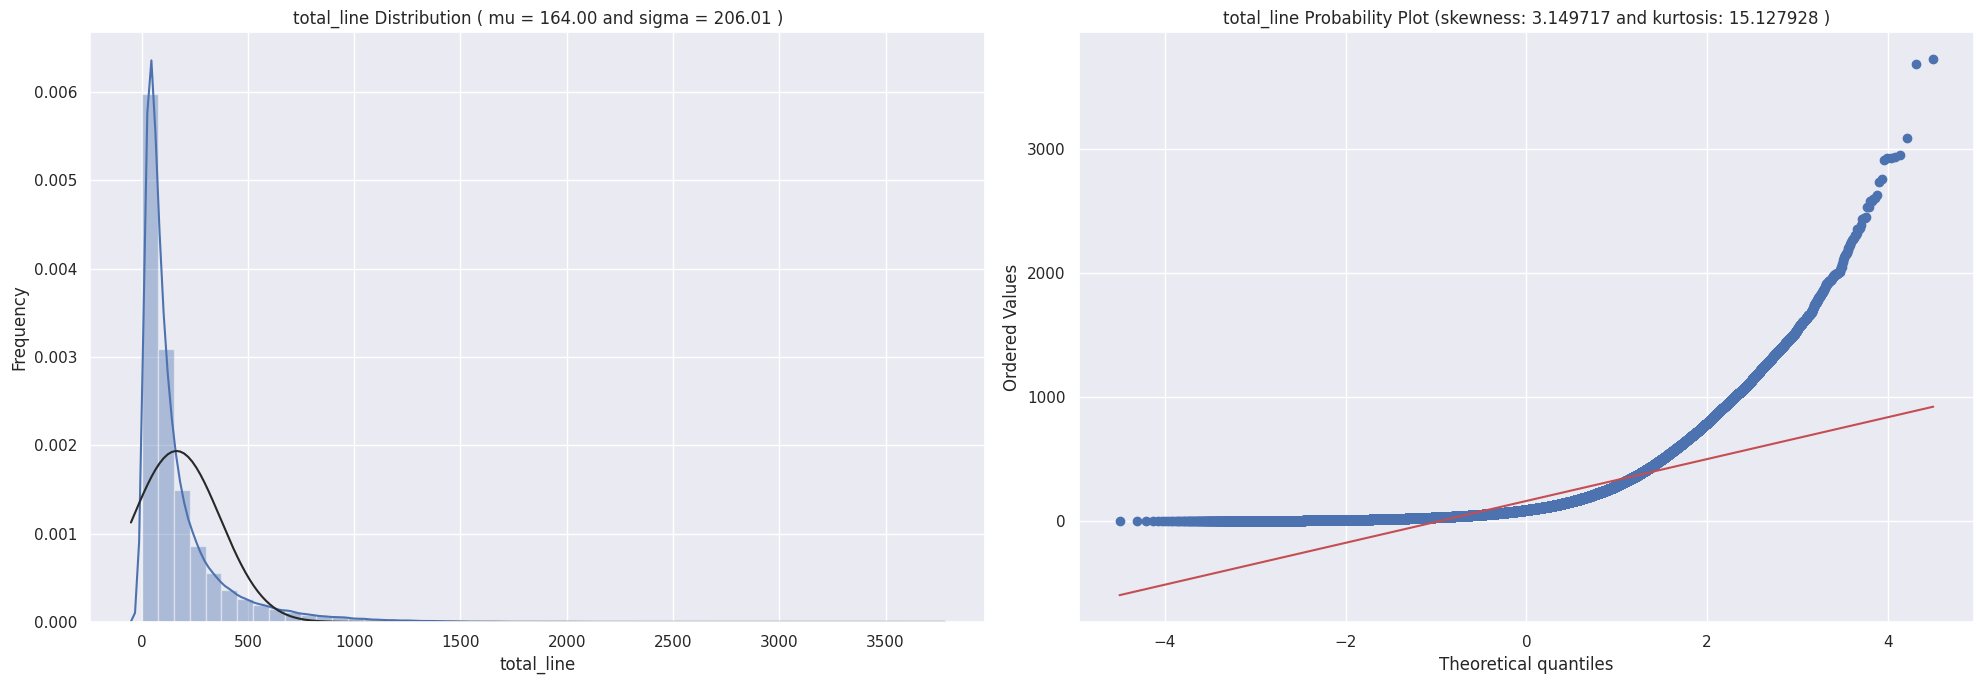

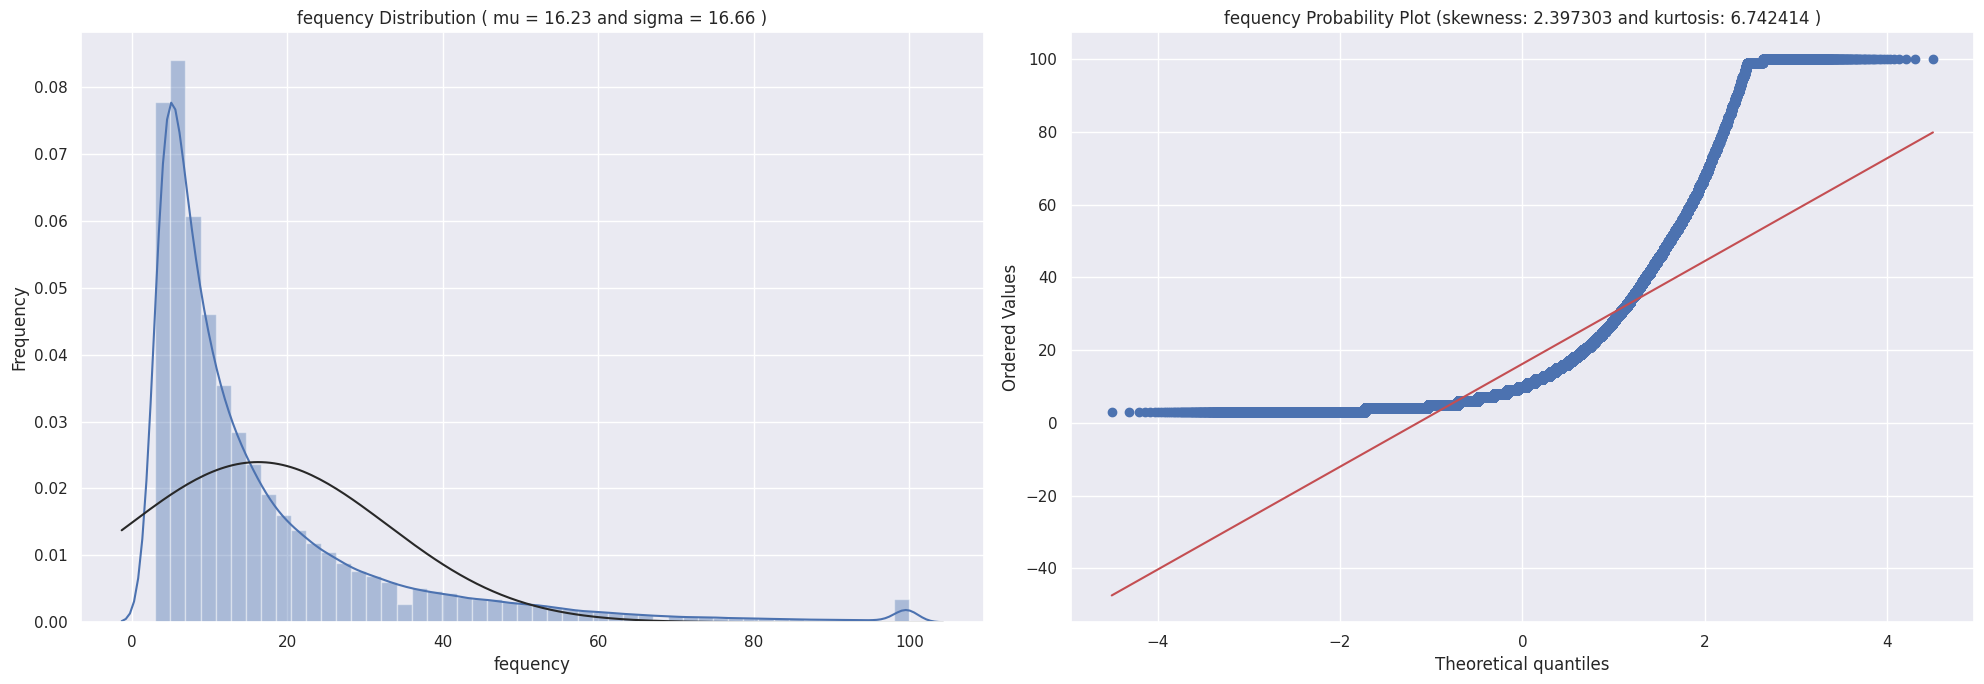

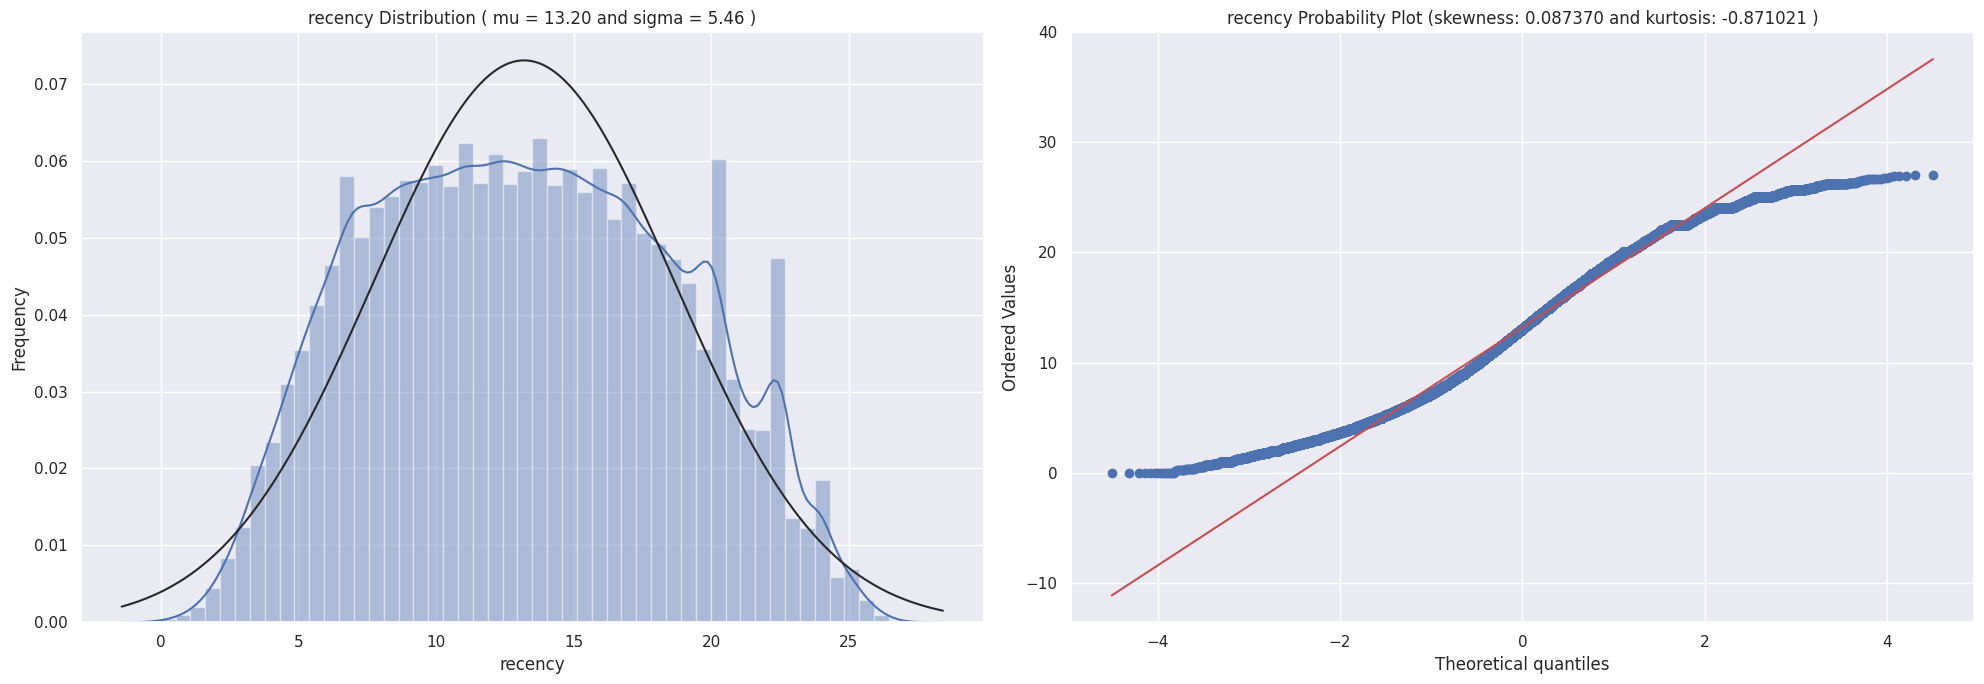

In [ ]:
for i in cus_orderdetail_df.iloc[1,1:].index:
    QQ_plot(cus_orderdetail_df, i)

### Nhận xét dựa trên biểu đồ, bảng thống kê dữ liệu order, dữ liệu deparment, dữ liệu aisle:
1. Phân phối dữ liệu về reordered 0, reordered 1, fequency, total line
- Là phân phối lệch phải, với tính chất chung là Mode < Median < Mean. Phần dữ liệu ngoại lệ (Outliers) đang kéo giá trị Trung Bình về phía cuối.
- Về độ nhọn thì cả 4 thông tin này đều có độ nhọn lớn hơn 1, đặc biệt thông tin reordered 1 lớn hơn 21.

Những điều trên có thể cho ta thấy: 4 thông tin reordered 0, reordered 1, fequency, total line đang có nhiều phần dữ liệu ngoại lệ làm phân phối dữ liệu lệch phải. Và phần lớn các giá trị của dữ liệu tập trung ở phía đầu, còn phần đuôi là các dữ liệu ngoại lệ.

2. Phân phối của dữ liệu về recency

- Là phân phối gần với phần phối chuẩn (phân phối có đường cong chuông) so với , với độ lệch nhỏ gần bằng 0.1, và độ nhọn nhỏ hơn 0 và gần -1. Nhưng hình dạng phân phối có nhiều hơn 1 đỉnh. Dữ liệu đa số tập trung ở trung tâm dữ liệu.Không có dữ liệu ngoại lệ.

Đánh giá từ bản thân:
 - Từ dữ liệu total line, với giá tri trung bình là 164, có thể thấy mức độ mua sắm rất lớn trên platform Instacart.Có nhiều yếu tố tạo nên vấn đề này:
 1. Từ dữ liệu deparment và aisle: có thể thấy sự đa dạng trong nhóm/ ngành sản phẩm được cung cấp đến người dùng: không chỉ đồ ăn, đồ uống, còn về sản phẩm thuốc, làm đẹp, sản phẩm gia đình,...
 2. Sự thuận tiện của vấn đề đặt hàng online. Như đề cập ở trên, Instacart có 3 đối tượng chính, trong đó có: Người mua sắm cá nhân, họ sẽ là người giúp người dùng mua sắm và lựa chọn sản phẩm họ đặt hàng ở những cửa hàng mà người dùng đã lựa chọn đặt hàng, sau đó được vận chuyển đến tận nơi.
 3. Cũng về sự thuận tiện, để mua sắm chúng ta gần như không thể mua hết những thứ ta cần ở một cửa hàng, mà cần phải qua các cửa hàng khác, nhưng với sự tích hợp nhiều cửa hàng với nhiều ngành hàng khác nhau. Chúng ta dễ dàng đạt được điều mong muốn.
 4. Với dữ liệu recency, là thời gian giữa những lần đặt hàng, giá trị trung bình là 13 ngày, có thể thấy cùng với sự thuận tiện một lần đặt sẽ là một lượng lớn các sản phẩm, việc ngay lập tức mua sắm tiếp là ít xảy ra, nên khoảng thời gian này gần như phân bố trong khoảng 1 tháng đổ lại. Và tất nhiên không quên những chương trình khuyến mãi, mà người dùng có thể chờ đến đó mới mua sắm để tiết kiệm.


### Phân tích sản phẩm theo ngành hàng.

In [ ]:
department_product_df = duckdb.sql('''
select count(t.product_id) as number_of_product,
department,
from order_products_prior t
left join product p on t.product_id = p.product_id
left join deparment d on p.department_id = d.department_id
group by 2
order by count(t.product_id) desc

''').fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
department_themost_df = duckdb.sql('''
select
    case when department in ('produce', 'dairy eggs','snacks','beverages','frozen','pantry') then 'else'
      else department end department,
    sum(number_of_product) as number_of_product
from department_product_df
group by 1

''').fetchdf()

In [ ]:
department_product_dim_df = duckdb.sql('''
select
    product_name,
    department
from product p
left join deparment d on p.department_id = d.department_id
group by 1, 2

''').fetchdf()

#### Biểu đồ tròn và bubble lần lượt thể hiện tỉ lệ và phân bổ của các nhóm/ngành hàng

In [ ]:
fig = px.pie(department_themost_df, values='number_of_product', names='department', title='Tỉ lệ ngành/nhóm hàng produce,dairy eggs,snacks,beverages,frozen,pantry trong đơn hàng')
fig.show()

In [ ]:

fig = px.scatter(department_product_df, x="number_of_product", y="department",
	         size="number_of_product", color="department",
                 hover_name="department", log_x=True, size_max=40, title="Sự phân bổ các nhóm/ngành hàng trong đơn hàng" )
fig.show()

Nhận xét về ngành hàng theo số lượng sản phẩm trong đơn hàng.

- Dựa vào dữ liệu tổng hợp bên trên, có thể thấy sự phân hóa rõ rệt giữa những nhóm/ngành hàng được thiết yếu được sử dụng hàng ngày và các nhóm/ngành hàng chỉ dùng cho những tần suất sử dụng ít.

- Ví dụ đối với ngành sản phẩm "Produce": sẽ bao gồm các sản phẩm về trái cây tươi (fresh fruit), rau củ quả tươi (fresh vegetables) hay các loại thảo mộc (herbs). Từ các loại sản phẩm có thể dễ hiểu tại sao ngành hàng này lại có lượng đặt hàng lớn so với các ngành hàng khác.

- Chỉ 6 ngành hàng 'produce', 'dairy eggs','snacks','beverages','frozen','pantry' chiếm tới gần 76% tổng số lượt đặt hàng, còn lại là 14 ngành hàng khác.

Dựa trên cá dữ liệu trên ta có thể:

1. Đánh giá được các ngành hàng đang là thế mạnh, giữ vững và đẩy mạnh bằng đảm bảo chất lượng sản phẩm, các chương trình khuyến mãi, tri ân, giảm giá cuối tuần, sự kiện.

2. Các ngành hàng chưa là thế mạnh, về bản chất đó là các ngành hàng mà sản phẩm đặt biệt, tiêu thụ ở một mức độ nhất định nhưng nếu gạch bỏ thì sẽ gây thiếu hụt về độ hấp dẫn của nền tảng. Theo dõi các chỉ số để đảm bảo các ngành hàng này đang có độ ổn định theo tính chất của sản phẩm.

## Khai thác luật kết hợp (Association Rules Mining - Apriori Algorithm.)

Có thể xem đây là một phương pháp khám phá mối liên hệ giữa các biến trong một tập dữ liệu thông qua tần số của các biến. Tham khảo thêm ở : https://athena.ecs.csus.edu/~mei/associationcw/Apriori.html

Sẽ có 3 chỉ số chính chúng ta cần quan tâm: support, confidence và lift

1. Support: là tần suất xuất hiện của một sản phẩm hoặc một cụm sản phẩm trong tập dữ liệu. Công thức như sau: \begin{align}
        Support(AB) = \frac{Tần\, suất \, AB}{Tổng\, dòng \, hàng}
    \end{align}


2. Confidence: Đo mối liên kết số lần sản phẩm B được mua với điều kiện sản phẩm A được mua. Công thức như sau: \begin{align}
        Confidence(AB) = \frac{Tần\, suất \, AB}{Tần \, suất \, A}
    \end{align}


3. Lift: là thước đo mối liên kết giữa hai sản phẩm là có hay không, hay hai sản phẩm này chỉ xuất hiện cùng nhau một cách ngẫu nhiên. Công thức như sau: \begin{align}
        Lift(AB) = \frac{Support(AB)}{Support(A) * Support(B)}
    \end{align}

In [ ]:
import pandas as pd
import numpy as np
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display

In [ ]:
orders = order_products_prior.set_index('order_id')['product_id'].rename('item_id')

In [ ]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else:
        return pd.Series(Counter(iterable)).rename("freq")


# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().to_numpy()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]

        for item_pair in combinations(item_list, 2):
            yield item_pair


# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB',
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]

def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)

    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])


    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

In [ ]:
rules = association_rules(orders, 0.01)

Starting order_item:               32434489
Items with support >= 0.01:           10906
Remaining order_item:              29843570
Remaining orders with 2+ items:     3013325
Remaining order_item:              29662716
Item pairs:                        30622410
Item pairs with support >= 0.01:      48751



In [ ]:
product   = product.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, product).sort_values('lift', ascending=False)

In [ ]:
rules_final.head(10)

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Organic Strawberry Chia Lowfat 2% Cottage Cheese,Organic Cottage Cheese Blueberry Acai Chia,306,0.010155,1163,0.038595,839,0.027843,0.263113,0.364720,9.449868
1,Grain Free Chicken Formula Cat Food,Grain Free Turkey Formula Cat Food,318,0.010553,1809,0.060033,879,0.029170,0.175788,0.361775,6.026229
3,Organic Fruit Yogurt Smoothie Mixed Berry,Apple Blueberry Fruit Yogurt Smoothie,349,0.011582,1518,0.050376,1249,0.041449,0.229908,0.279424,5.546732
9,Nonfat Strawberry With Fruit On The Bottom Gre...,"0% Greek, Blueberry on the Bottom Yogurt",409,0.013573,1666,0.055288,1391,0.046162,0.245498,0.294033,5.318230
10,Organic Grapefruit Ginger Sparkling Yerba Mate,Cranberry Pomegranate Sparkling Yerba Mate,351,0.011648,1731,0.057445,1149,0.038131,0.202773,0.305483,5.317849
11,Baby Food Pouch - Roasted Carrot Spinach & Beans,"Baby Food Pouch - Butternut Squash, Carrot & C...",332,0.011018,1503,0.049878,1290,0.042810,0.220892,0.257364,5.159830
12,Unsweetened Whole Milk Mixed Berry Greek Yogurt,Unsweetened Whole Milk Blueberry Greek Yogurt,438,0.014535,1622,0.053828,1621,0.053794,0.270037,0.270204,5.019798
23,Uncured Cracked Pepper Beef,Chipotle Beef & Pork Realstick,410,0.013606,1839,0.061029,1370,0.045465,0.222947,0.299270,4.903741
24,Organic Mango Yogurt,Organic Whole Milk Washington Black Cherry Yogurt,334,0.011084,1675,0.055586,1390,0.046128,0.199403,0.240288,4.322777
2,Grain Free Chicken Formula Cat Food,Grain Free Turkey & Salmon Formula Cat Food,391,0.012976,1809,0.060033,1553,0.051538,0.216142,0.251771,4.193848


Từ những thông tin từ Assocation Rules - Thuật toán Apriori và các thông số liên quan ta có thể đưa ra một vài ý sau:

1. Có một hoặc không mối liên hệ giữa các sản phẩm. Ví dụ khi mua sữa chúng ta có xu hướng mua bánh mì, bơ. Khi này tần suất các sản phẩm xuất hiện cùng nhau sẽ được thể hiện rõ trong Assocation Rules.

2. Dựa vào các thông tin này chúng ta có thể đưa ra các khuyến mãi đính kèm, gợi ý các sản phẩm mà người dùng chưa từng thử trước đây hoặc là không ngờ là có tồn tại trong hàng ngàn sản phẩm.

3. Tăng doanh số nhờ các hoạt động gợi ý sản phẩm, bán kèm nhằm hạn chế số lượng sản phẩm phải bỏ đi vì hết hạn.

4. Từ thông tin các nhóm/ngành hàng tương ứng với sản phẩm, ta có thể hình dung phần nào về người dùng.Chẳng hạn:

    - Với những nhóm người hay mua rươụ, các thức uống có cồn với tần suất cao, họ sẽ ít mua những sản phẩm tươi sống. --> Có thể phỏng đoán phần nào thói quen, lối sống của người dùng.

    - Với những người hay mua trứng, sữa, các đồ dành cho em bé --> họ là những người có gia đình, thời gian mua sắm không nhiều.


## Thời gian đặt hàng trong tuần và khoảng cách giữa các lần đặt hàng

#### Line chart thể hiện sự thay đổi tần suất mua hàng theo khung giờ trong ngày và ngày trong tuần

In [ ]:
order_hour_df = order.groupby(["order_hour_of_day"])["order_id"].aggregate("count").reset_index()
fig = px.line(order_hour_df, x='order_hour_of_day', y='order_id', markers=True, title="Tần suất mua hàng theo giờ trong ngày")
fig.show()

In [ ]:
order_dayweek_df = order.groupby(["order_dow"])["order_id"].aggregate("count").reset_index()
fig = px.line(order_dayweek_df, x='order_dow', y='order_id', markers=True, title="Tần suất mua hàng theo ngày trong tuần")
fig.show()

#### Heatmap char thể hiện sự thay đổi về nhóm/ngành hàng theo khung giờ trong ngày và ngày trong tuần

In [ ]:
order_dow_hour_df = order.groupby(["order_dow","order_hour_of_day"])["order_id"].aggregate("count").reset_index()

In [ ]:
def convert_dow_hour(x):
  if x == 0:
    return 'sunday'
  elif x == 1:
    return 'monday'
  elif x == 2:
    return 'tuesday'
  elif x == 3:
    return 'wednesday'
  elif x == 4:
    return 'thursday'
  elif x == 5:
    return 'friday'
  else:
    return 'saturday'

order_dow_hour_df['order_dow'] = order_dow_hour_df['order_dow'].apply(convert_dow_hour)
order_dow_hour_df['order_hour_of_day'] = order_dow_hour_df['order_hour_of_day'].apply(lambda x: 'morning' if x < 12 else 'afternoon' if x < 18 else 'evening')

In [ ]:
fig = go.Figure(data=go.Heatmap(
        z=order_dow_hour_df['order_id'],
        x=order_dow_hour_df['order_dow'],
        y=order_dow_hour_df['order_hour_of_day'],
        colorscale='Viridis'))

fig.update_layout(
    title='Tần suất mua hàng theo ngày trong tuần và khoảng thời gian trong ngày',
    xaxis_nticks=36)

fig.show()

In [ ]:
order_copy = order.copy()

In [ ]:
hod_department_df = duckdb.sql('''
select count(t.product_id) as number_of_product,
d.department,
order_hour_of_day
from order_copy a
left join order_products_prior t on t.order_id = a.order_id
left join product p on t.product_id = p.product_id
left join deparment d on p.department_id = d.department_id
where d.department is not null
group by 2,3
order by count(t.product_id) desc

''').fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
fig = go.Figure(data=go.Heatmap(
        z=hod_department_df['number_of_product'],
        x=hod_department_df['department'],
        y=hod_department_df['order_hour_of_day'],
        colorscale='Viridis'))

fig.update_layout(
    title='Tần suất mua sản phẩm theo ngành hàng các giờ trong ngày',
    xaxis_nticks=36)

fig.show()

In [ ]:
dow_department_df = duckdb.sql('''
select count(t.product_id) as number_of_product,
d.department,
order_dow
from order_copy a
left join order_products_prior t on t.order_id = a.order_id
left join product p on t.product_id = p.product_id
left join deparment d on p.department_id = d.department_id
where d.department is not null
group by 2,3
order by count(t.product_id) desc

''').fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
fig = go.Figure(data=go.Heatmap(
        z=dow_department_df['number_of_product'],
        x=dow_department_df['department'],
        y=dow_department_df['order_dow'],
        colorscale='Viridis'))

fig.update_layout(
    title='Tần suất mua sản phẩm theo ngành hàng các ngày trong tuần',
    xaxis_nticks=36)

fig.show()

Nhận xét dữ liệu mua hàng theo ngày trong tuần và thời gian trong ngày:

- Dựa vào các biểu đồ về tần suất mua hàng trong các khung giờ trong ngày, các ngày trong tuần và theo đó là các ngành hàng được mua ta có thể thấy một số hành vi của người dùng như sau:

1. Với các khung giờ trong ngày thì thấy đa phần người dùng tập trung mua từ 7 giờ sáng đến cao điểm là khung giờ 10 đến 15 giờ, sau đó giảm dần vào lúc 20 giờ.

2. Với các ngày trong tuần mọi người thường sẽ tập trung chủ yếu vào Chủ Nhật và Thứ Hai, Có thể hiểu ngày nghỉ mọi người sẽ có thời gian mua sắm, nhưng về Thứ Hai, theo đánh giá cá nhân là sẽ phần lớn người làm cả Chủ Nhật họ chưa kịp đặt đồ nên họ sẽ đặt ở Thứ Hai.

Kết luận:
- Dựa vào tần suất theo ngày và theo giờ, việc sắp xếp lực lượng thường trực người mua sắm cá nhân phục vụ người dùng rất quan trọng.
- Nhóm/ ngành hàng, phản ánh mong muốn của người dùng theo từng khung giờ thời gian trong ngày và tuần. Đảm bảo chất lượng sản phẩm luôn phải là ưu tiên hàng đầu. Ví dụ, người dùng đặt đồ tươi sống vào 7h sáng, thời gian hẹn giao là 8h. không thể lấy đồ từ tối hôm qua, mà phải đảm bảo độ tươi ngon. Nên cách phân phối sản phẩm rất quan trọng.

# Các insight đúc kết đến hiện tại

1. Sự phân bố dữ liệu của các thông tin reordered 0, reordered 1, fequency, total line, recency cho ta cái nhìn tổng quan về tình hình kinh doanh của nền tảng Instacart (theo dữ liệu được cung cấp). Cũng như cho thấy các ưu điểm của nhà cung cấp này về: sự thuận tiện, dịch vụ, hàng hóa,...

2. Sản phẩm theo ngành hàng: không phải tất cả các sản phẩm đều bán chạy. Việc lựa chọn và tối ưu hóa sản phẩm để tăng khả năng bán sản phẩm.

3. Mối liên kết giữa các sản phẩm là rất quan trọng. Từ đó việc gợi ý sản phẩm là một hình thức thúc đẩy doanh số bán sản phẩm. Ngoài ra là thu hút người dùng cho những sản phẩm tiềm năng mà tại đó có thể người dùng sẽ thích sản phẩm.

4. Việc sắp xếp nguồn nhân lực người mua sắm cá nhân rất quan trọng trong việc đảm bảo phục vụ người dùng tốt nhất. Tiếp đó là vận chuyển hàng hóa đảm bảo các sản phẩm luôn là chất lượng tốt. Khung giờ và thời gian mua sắm của khách hàng sẽ cho ta biết thêm về vấn đề này.

# Phát triển tiếp theo


1. Gom nhóm khách hàng và sản phẩm. Việc theo dõi sự thay đổi về tần suất mua sắm của khách hàng hay sản phẩm chúng ta không thể chi tiết đến từng khách hàng, sản phẩm được. Cần có sự gom nhóm để đảm bảo việc giữ chân thu hút khách hàng được tốt hơn.

2. Dữ liệu đã có thông tin về sản phẩm được reordered hay không, dựa vào đó chúng ta có thể đưa ra dự đoán rằng ở đơn hàng kế tiếp những sản phẩm đó có được khách hàng mua tiếp hay không? Đó có thể là một lợi thế lớn. Từ đó có thể đưa ra các chiến lược tiếp thị nhằm thu hút khách hàng.

# Clustering dữ liệu

### Chuẩn bị dữ liệu và training model

In [ ]:
error = 0.0001
cus_orderdetail_df['fequency_log'] = np.log(cus_orderdetail_df['fequency'])
cus_orderdetail_df['reordered_0_log'] = np.log(cus_orderdetail_df['reordered_0'])
cus_orderdetail_df['total_line_log'] = np.log(cus_orderdetail_df['total_line'])
cus_orderdetail_df['recency_log'] = np.log(cus_orderdetail_df['recency']+ error)
cus_orderdetail_df['reordered_1_log'] = np.log(cus_orderdetail_df['reordered_1']+ error)
feature_vector = ['fequency_log','recency_log','reordered_0_log','reordered_1_log','total_line_log']
X_subset = cus_orderdetail_df[feature_vector]
scaler = StandardScaler()
X_subset[feature_vector] = scaler.fit_transform(X_subset[feature_vector])

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=101)
    kmeans.fit(X_subset)
    score = silhouette_score(X_subset, kmeans.labels_)
    silhouette_coefficients.append(score)

#### Sự thay đổi hệ số silhouette theo từng Clusters

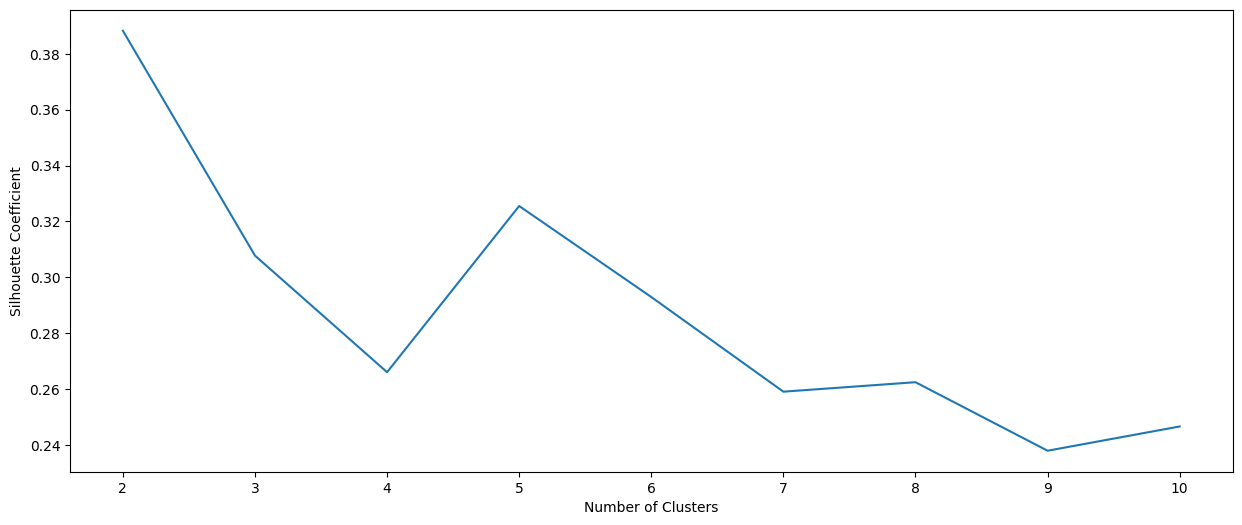

In [ ]:
plt.figure(figsize = (15,6))
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Chọn số lượng nhóm và đánh giá

In [ ]:
cluster_centers = dict()

cluster_num = [2, 5, 8]
for n_clusters in cluster_num:

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=101)
    cluster_labels = clusterer.fit_predict(X_subset)
    silhouette_avg = silhouette_score(X = X_subset, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_subset, labels = cluster_labels)

In [ ]:
## get the data of cluster center
features = ['fequency','recency','reordered_0','reordered_1','total_line']
cent_transformed = scaler.inverse_transform(cluster_centers[2]['cluster_center'])
cluster_2 = pd.DataFrame(np.exp(cent_transformed),columns=features)
cent_transformed = scaler.inverse_transform(cluster_centers[5]['cluster_center'])
cluster_5 = pd.DataFrame(np.exp(cent_transformed),columns=features)
cent_transformed = scaler.inverse_transform(cluster_centers[8]['cluster_center'])
cluster_8 = pd.DataFrame(np.exp(cent_transformed),columns=features)

## add the column Number Cluster

cluster_2['Number_Cluster'] = 'Cluster_2'
cluster_5['Number_Cluster'] = 'Cluster_5'
cluster_8['Number_Cluster'] = 'Cluster_8'

## reset index
cluster_2 = cluster_2.reset_index()
cluster_5 = cluster_5.reset_index()
cluster_8 = cluster_8.reset_index()

## concat the datafarms

cluster_center = pd.concat([cluster_2, cluster_5, cluster_8])
cluster_center.rename(columns={'index':'Cluster'}, inplace=True)

In [ ]:
features = ['fequency','recency','reordered_0','reordered_1','total_line']
for i in cluster_num:
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 2 clusters the silhouette score is 0.39
Centers of each cluster:
    fequency    recency  reordered_0  reordered_1  total_line
0  22.986527   9.514961    95.705175   135.810610  245.437618
1   6.371472  14.061044    27.531854    10.940061   43.863426
--------------------------------------------------
for 5 clusters the silhouette score is 0.33
Centers of each cluster:
    fequency    recency  reordered_0  reordered_1  total_line
0   5.431926  16.513178    18.917310     7.552086   29.065636
1   7.009978   6.263368    30.544249    17.698488   53.186440
2  11.189997  14.899654    62.442581    48.389395  117.306976
3   3.799953  13.408721    13.878253     0.000100   13.878253
4  35.331735   7.527864   121.972538   239.590382  377.284325
--------------------------------------------------
for 8 clusters the silhouette score is 0.26
Centers of each cluster:
    fequency    recency  reordered_0  reordered_1  total_line
0   5.828582  16.492879    31.849213    11.882100   46.851167
1  22.245

In [ ]:
cus_orderdetail_df['clusters_2'] = cluster_centers[2]['labels']
cus_orderdetail_df['clusters_5'] = cluster_centers[5]['labels']
cus_orderdetail_df['clusters_8'] = cluster_centers[8]['labels']
cus_orderdetail_df.head()

,user_id,reordered_0,reordered_1,total_line,fequency,recency,fequency_log,reordered_0_log,total_line_log,recency_log,reordered_1_log,clusters_2,clusters_5,clusters_8
0,1,19.0,51.0,70.0,11,17.272727,2.397895,2.944439,4.248495,2.849135,3.931828,1,2,0
1,2,121.0,105.0,226.0,15,15.200000,2.708050,4.795791,5.420535,2.721302,4.653961,0,2,1
2,3,33.0,55.0,88.0,12,11.083333,2.484907,3.496508,4.477337,2.405452,4.007335,1,2,7
3,4,17.0,1.0,18.0,5,11.000000,1.609438,2.833213,2.890372,2.397904,0.000100,1,0,3
4,5,28.0,18.0,46.0,5,9.200000,1.609438,3.332205,3.828641,2.219214,2.890377,1,1,5


#### Biểu đồ tròn thể hiện phân bổ các nhóm theo số lượng từng nhóm đã chọn

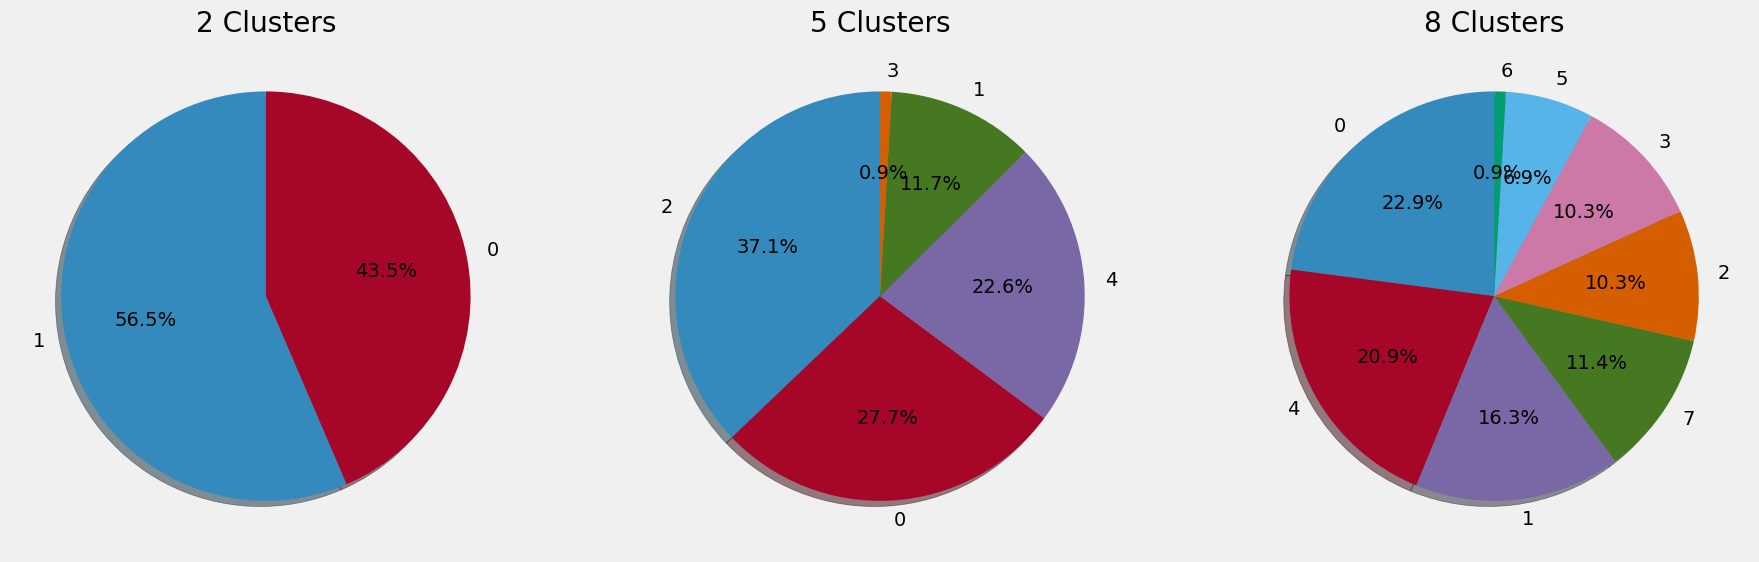

In [ ]:
plt.style.use(['fivethirtyeight', 'bmh'])
fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
market = cus_orderdetail_df.clusters_2.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('2 Clusters')
f1 = fig.add_subplot(132)
market = cus_orderdetail_df.clusters_5.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('5 Clusters')
f1 = fig.add_subplot(133)
market = cus_orderdetail_df.clusters_8.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('8 Clusters')
plt.show()

In [ ]:
import plotly as py
import plotly.graph_objs as go
#py.offline.init_notebook_mode()
import matplotlib.mlab as mlab
import matplotlib.cm as cm

x_data = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6','Cluster 7']
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)',
          'rgba(22, 80, 57, 0.5)', 'rgba(127, 65, 14, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']

features = ['fequency','recency','reordered_0','reordered_1','total_line']
cutoff_quantile = 95


def cluster_visual(column_label,k, feature_column, target):
    sns.set(style='darkgrid', font_scale=1.0, rc={"figure.figsize": [14, 6]})

    for i in range(k):
        plt.scatter(cus_orderdetail_df[cus_orderdetail_df[column_label] == i][feature_column], \
                    cus_orderdetail_df[cus_orderdetail_df[column_label] == i][target], s=20,
                    label='Cluster ' + str(i))

        plt.scatter(cluster_center[(cluster_center['Number_Cluster'] == column_label.capitalize()) & (
                cluster_center['Cluster'] == i)][feature_column], \
                    cluster_center[(cluster_center['Number_Cluster'] == column_label.capitalize()) & (
                            cluster_center['Cluster'] == i)][target], s=300 \
                    , c='black')
    plt.xlabel(feature_column)
    plt.ylabel(target)
    plt.title('Cluster of ' + feature_column.capitalize() + ' with ' + target)
    plt.legend()
    plt.show()

#### Chi tiết các trường sau khi phân nhóm

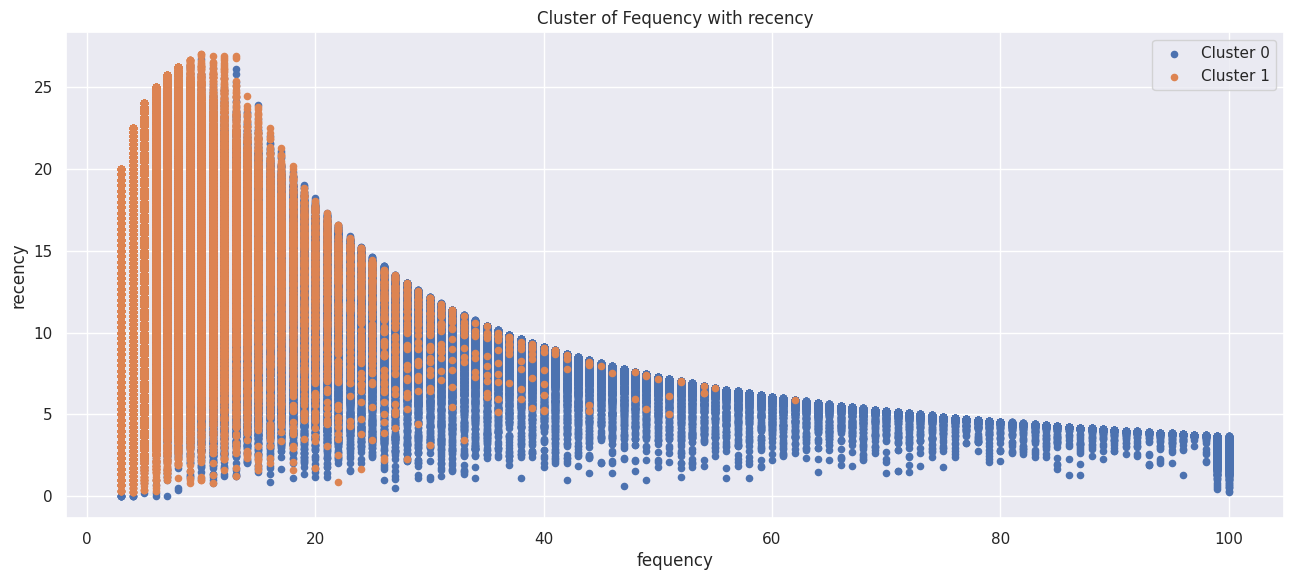

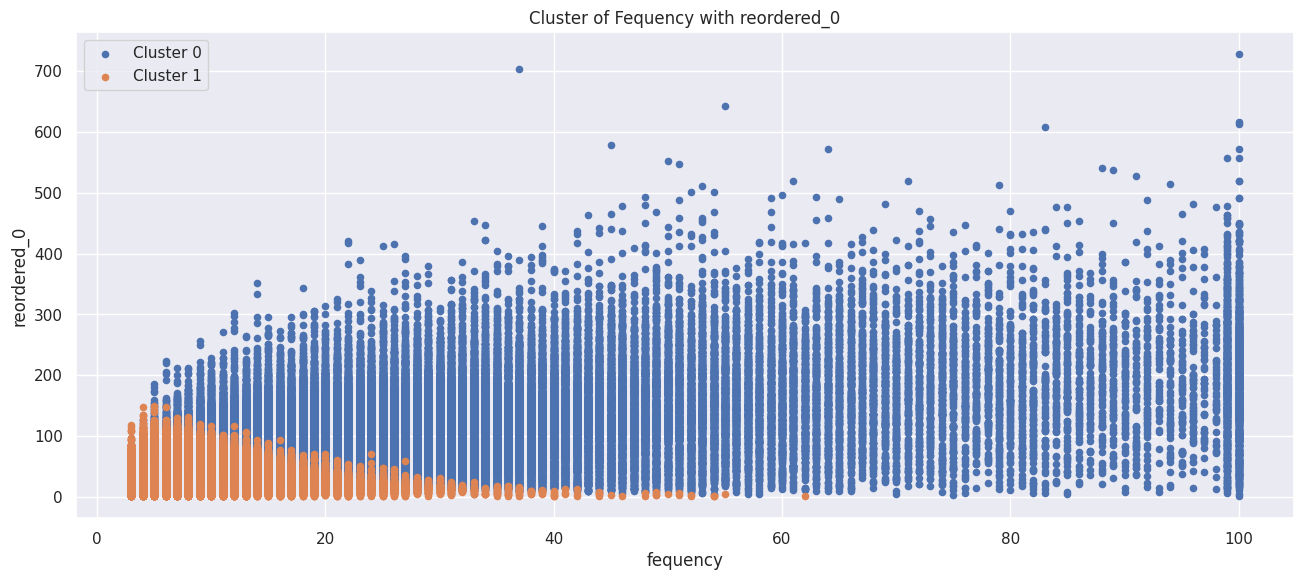

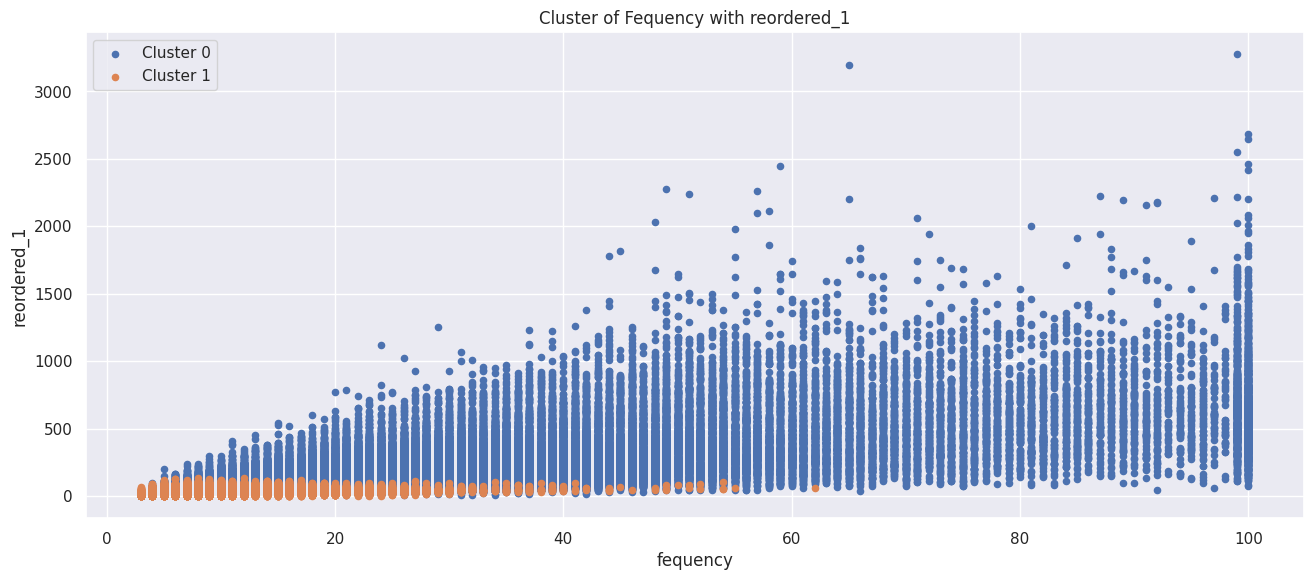

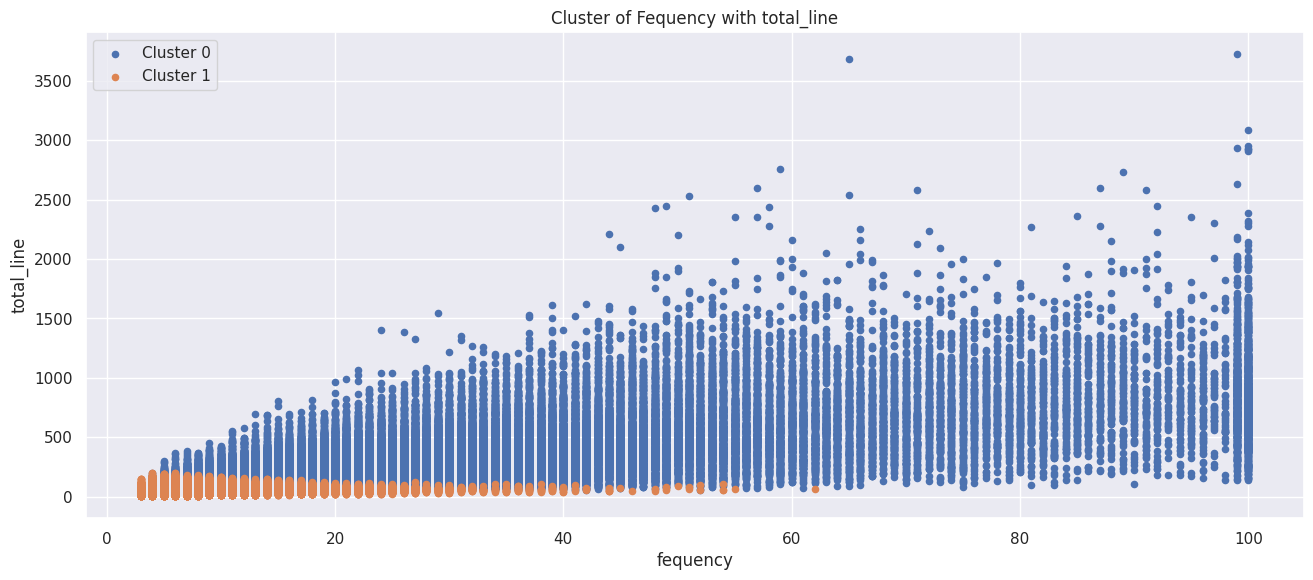

In [ ]:
list_target = ['recency','reordered_0','reordered_1','total_line']
feature_column = 'fequency'
k = 2
column_label = 'clusters_2'

for idx,val in enumerate(list_target):
  cluster_visual(column_label, k, feature_column, val)

Gom nhóm Khách hàng:

1. Thuật toán: sử dụng K-Mean.

2. Các yếu tố dùng để phân nhóm:

  - Tần suất mua hàng (số lượng đơn hàng) - Fequency
  - Khoảng cách giữa các lần mua hàng - Recency
  - Tổng số lượng mã hàng đã mua - Total Line
  - Sô lần mua lại một mã sản phẩm - Reordered 1
  - Số lần không mau lại một mã sản phẩm - Reordered 0

3. Sử dụng hệ số silhouette để xác định số cụm tối ưu. Giá trị của silhouette trong khoảng từ -1 tới 1. Trong đó:

  - 1: Các điểm được gán vào một nhóm và các nhóm có thể dễ dàng phân biệt.
  - 0: Các nhóm đang overlap.
  - -1 : Các điểm đang gán sai nhóm.

4. Số lượng nhóm tốt nhất hiện tại là 2. Dựa vào hệ số silhouette.

5. Số lượng khách hàng của nhóm 0 chiếm 43,5% còn lại là nhóm 1.

Nhận xét:

- Dựa vào thông tin fequency, recency, total line, reordered 0/1 của điểm trung tâm ta thấy sự khác biệt giữa 2 nhóm khách hàng. Trừ thông tin recency thì các thông tin còn lại nhóm 0 đều cao hơn nhóm 1.

- Nhóm 0 chính là những khách hàng cần ưu tiên theo dõi và chăm sóc, vì đây là nhóm mua hàng thường xuyên, số lượng mua hàng cao. Có thể nghiên cứu định tính để hiểu sâu sắc hơn về nhóm này. Đặc biệt nếu có khách hàng nhóm này rời bỏ cần theo dõi số luợng và tìm hiểu nguyên nhân để ngăn chặn.

- Nhóm khách hàng còn lại (nhóm 1) dù các thông số không bằng nhóm 0 nhưng cũng không thể  bỏ qua, cần thêm các yếu tố định tính để hiểu thêm nhóm này để có các chiến lược cụ thể hơn.

- Số lượng nhóm 5 và 8, dựa vào thông tin của điểm trung tâm, có thể thấy các về khách hàng thường xuyên mua sắm sẽ có số lượng lớn hơn 1 nhóm, và ngược lại cũng vậy. Tùy theo hoạt động công ty mà sẽ chọn số lượng nhóm phù hợp. Vì trên hết đều phải dựa vào tình hình hoạt động mà đưa ra quyết định phù hơp, còn dữ liệu là nguồn tham khảo.